# Scanorama Data Integration with Herring Datasets
## Created by: Fallon Ratner 

In [1]:
import numpy as np
import scanpy as sc
import scanorama
import os 

In [2]:
#set personal wd
os.chdir("C:/Users/fallo\Documents/Internship_2023/transcriptome_comp/data/Herring")
# Read in Herring files
ga22 = sc.read("ga22_cleaned_count_matrices.h5ad")
ga24 = sc.read("ga24_cleaned_count_matrices.h5ad")
ga34 = sc.read("ga34_cleaned_count_matrices.h5ad")

In [4]:
# Combine the AnnData objects into one
combo_adata = sc.concat([ga22, ga24, ga34], axis = 0, join = 'outer')
combo_adata

AnnData object with n_obs × n_vars = 26580 × 26747
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_d

In [5]:
# Variance Stabilizing Transformation - VST
sc.pp.log1p(combo_adata, copy=False)
sc.pp.highly_variable_genes(combo_adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key='batch')

In [6]:
# Detect Variable Genes
var_genes_all = combo_adata.var.highly_variable
print("Highly variable genes: %d" % sum(var_genes_all))

print("Highly variable genes intersection: %d" % sum(combo_adata.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(combo_adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = combo_adata.var.highly_variable_nbatches > 0

# Calculate the variable genes (sum) for all batches
print("Any batch var genes: %d" % sum(var_genes_batch))
print("All data var genes: %d" % sum(var_genes_all))

# Identify variable genes that are the same between batches
print("Overlap: %d" % sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d" % sum(combo_adata.var.highly_variable_nbatches == 3))
print("Overlap batch intersection and all: %d" % sum(var_genes_all & combo_adata.var.highly_variable_intersection))

var_select = combo_adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

Highly variable genes: 2781
Highly variable genes intersection: 1347
Number of batches where gene is variable:
0    21466
1     2714
3     1347
2     1220
Name: highly_variable_nbatches, dtype: int64
Any batch var genes: 5281
All data var genes: 2781
Overlap: 2764
Variable genes in all batches: 1347
Overlap batch intersection and all: 1347


1347

In [7]:
#Data Integration
#First we need to create individual AnnData objects from each of the datasets.
# split per batch into new objects.
batches = combo_adata.obs['batch'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = combo_adata[combo_adata.obs['batch'] == batch,]

alldata

{'RL2103_ga22_v3': View of AnnData object with n_obs × n_vars = 10466 × 26747
     obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'O

In [8]:
#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

RL2103_ga22_v3
RL2107_ga24_v3
RL2121_ga34_v3


In [9]:
# Run Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
corrected[0].obsm['X_scanorama'].shape

# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in corrected]
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

Found 1347 genes among all datasets
[[0.         0.82497867 0.18106263]
 [0.         0.         0.49955476]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)
(26580, 100)


In [10]:
# add to the AnnData object, create a new object first
adata_sc = combo_adata.copy()
adata_sc.obsm["Scanorama"] = all_s

c:\Users\fallo\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


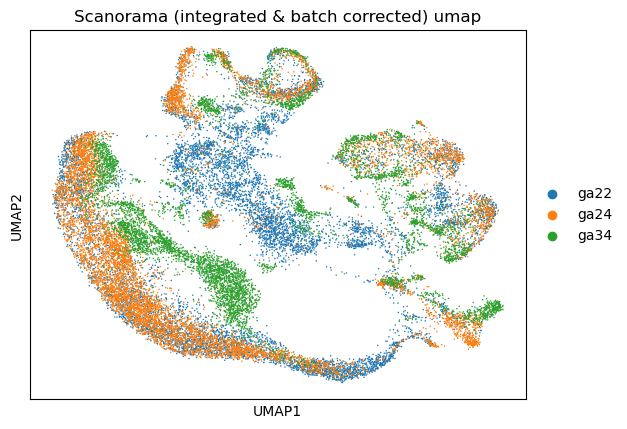

c:\Users\fallo\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


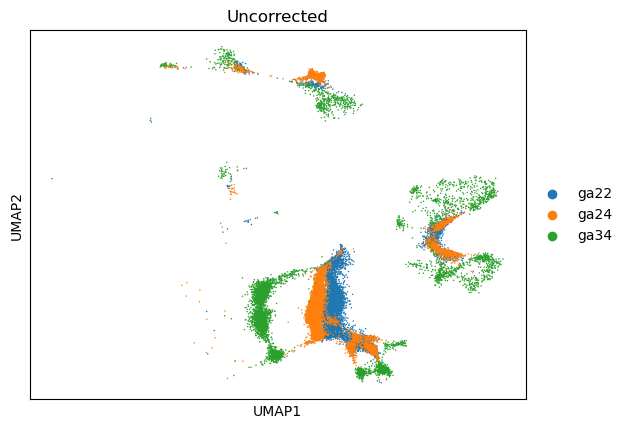

In [11]:
#perform umap
sc.pp.neighbors(adata_sc, n_pcs =30, use_rep = "Scanorama")
sc.tl.umap(adata_sc)
#map umap
sc.pl.umap(adata_sc, color="age", title="Scanorama (integrated & batch corrected) umap")
sc.pl.umap(combo_adata, color="age", title="Uncorrected")